# Machine Learning - Assignment II

**Authors:**  
Sezin Mumcu (15775070), Selin Yücelbak (14371553), Fehmi Aydemir (14194392)

This notebook focuses on analyzing and predicting online news article popularity through a comprehensive two-part exploration of various classification techniques. Using a dataset of 39,000 news articles with 58 features including metrics like word count, number of links, and content polarity, we'll develop models to classify articles as popular or unpopular based on a 1,400-shares threshold. Part A examines linear classifiers (Logistic Regression, Linear SVC, and K-Nearest Neighbors) with emphasis on feature scaling impacts, while Part B investigates tree-based methods (Decision Trees and Random Forests) including robustness analysis under varying noise conditions. The project encompasses key objectives including algorithm implementation, feature scaling analysis, hyperparameter optimization via grid search, model robustness testing, and comparative analysis of different classification approaches, all implemented in Python using scikit-learn and documented in a Jupyter Notebook with matplotlib visualizations.

## Initial Set-up

This section prepares our coding environment by importing essential Python libraries, setting a fixed random seed to ensure reproducible results across multiple runs, configuring matplotlib for enhanced visualization quality, and suppressing unnecessary warning messages that might clutter our output.

In [12]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, 
    precision_recall_fscore_support, 
    f1_score,
    precision_score,
    recall_score,
    roc_curve,
    auc
)

# Set random seed for reproducibility
np.random.seed(42)

# Configure matplotlib for better plotting
plt.style.use('default')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 12

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

## Data Loading and Exploration

In this section, we load the Online News Popularity dataset from the CSV file, examine its structure including feature types and basic statistics, remove non-predictive columns, and perform initial data inspection to understand the distribution of article shares and other key attributes that will inform our classification approach.

In [37]:
# Load the dataset
df = pd.read_csv('/Users/sezinmumcu/Desktop/Machine Learning/Assignment2_Data/OnlineNewsPopularity.csv')

# Strip leading and trailing spaces from column names
df.columns = df.columns.str.strip()

# Initial data inspection
print("Dataset Shape:", df.shape)
print("\nFirst few rows of the dataset:")
print(df.head())

print("\nDataset Info:")
print(df.info())

print("\nDescriptive Statistics:")
print(df.describe())

# Check for missing values
print("\nMissing Values:")
print(df.isnull().sum())

Dataset Shape: (39644, 61)

First few rows of the dataset:
                                                 url  timedelta  \
0  http://mashable.com/2013/01/07/amazon-instant-...      731.0   
1  http://mashable.com/2013/01/07/ap-samsung-spon...      731.0   
2  http://mashable.com/2013/01/07/apple-40-billio...      731.0   
3  http://mashable.com/2013/01/07/astronaut-notre...      731.0   
4   http://mashable.com/2013/01/07/att-u-verse-apps/      731.0   

   n_tokens_title  n_tokens_content  n_unique_tokens  n_non_stop_words  \
0            12.0             219.0         0.663594               1.0   
1             9.0             255.0         0.604743               1.0   
2             9.0             211.0         0.575130               1.0   
3             9.0             531.0         0.503788               1.0   
4            13.0            1072.0         0.415646               1.0   

   n_non_stop_unique_tokens  num_hrefs  num_self_hrefs  num_imgs  ...  \
0                  0

In [39]:
# Remove non-predictive columns
columns_to_drop = ['url', 'timedelta']
df_cleaned = df.drop(columns=columns_to_drop)

print("\nFeatures after removing non-predictive columns:", df_cleaned.shape[1])


Features after removing non-predictive columns: 59


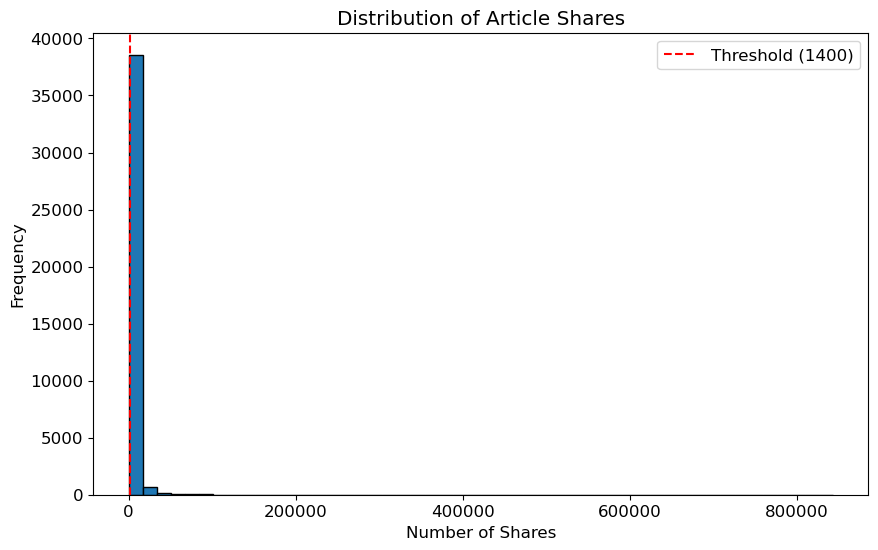

In [41]:
# Display distribution of the target variable (shares)
plt.figure(figsize=(10, 6))
plt.hist(df_cleaned['shares'], bins=50, edgecolor='black')
plt.title('Distribution of Article Shares')
plt.xlabel('Number of Shares')
plt.ylabel('Frequency')
plt.axvline(x=1400, color='r', linestyle='--', label='Threshold (1400)')
plt.legend()
plt.show()

In [43]:
# Display basic statistics of the target variable
print("\nTarget Variable (shares) Statistics:")
print(df_cleaned['shares'].describe())


Target Variable (shares) Statistics:
count     39644.000000
mean       3395.380184
std       11626.950749
min           1.000000
25%         946.000000
50%        1400.000000
75%        2800.000000
max      843300.000000
Name: shares, dtype: float64


In [31]:
# Count of articles above and below threshold
threshold = 1400
below_threshold = len(df_cleaned[df_cleaned['shares'] < threshold])
above_threshold = len(df_cleaned[df_cleaned['shares'] >= threshold])

print(f"\nArticles with < {threshold} shares: {below_threshold}")
print(f"Articles with >= {threshold} shares: {above_threshold}")
print(f"Class balance ratio: {above_threshold/below_threshold:.2f}")


Articles with < 1400 shares: 18490
Articles with >= 1400 shares: 21154
Class balance ratio: 1.14


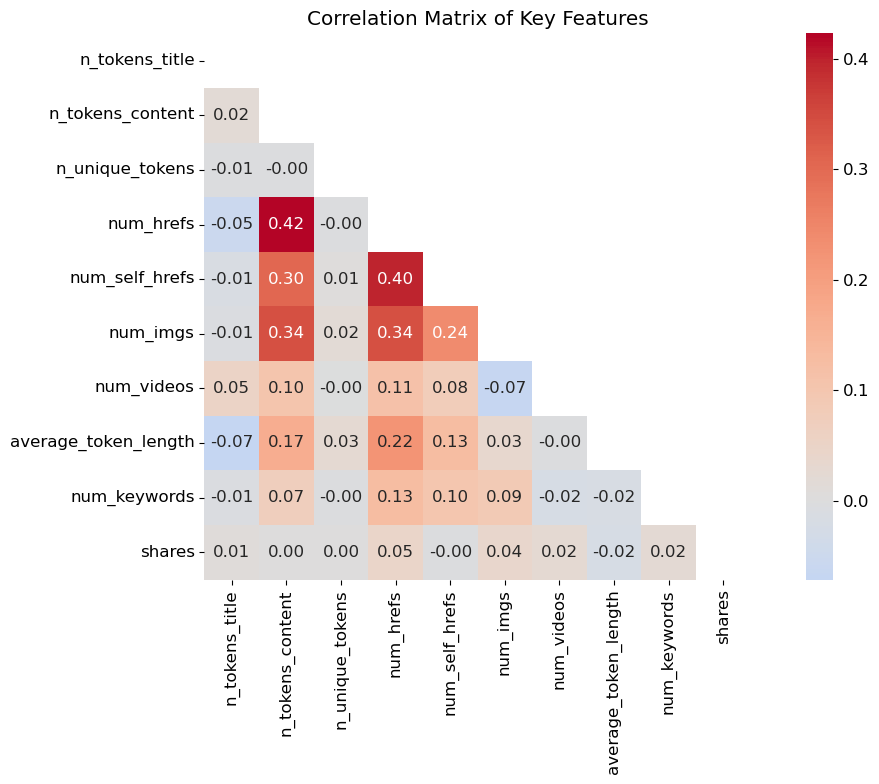

In [53]:
# Display correlation matrix for key features
important_features = [
    'n_tokens_title', 'n_tokens_content', 'n_unique_tokens',
    'num_hrefs', 'num_self_hrefs', 'num_imgs', 'num_videos',
    'average_token_length', 'num_keywords', 'shares'
]

plt.figure(figsize=(12, 8))
correlation_matrix = df_cleaned[important_features].corr()
# Create mask for the upper triangle
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, 
            mask=mask,
            annot=True, 
            cmap='coolwarm', 
            center=0,
            fmt='.2f',
            square=True)
plt.title('Correlation Matrix of Key Features')
plt.tight_layout()
plt.show()

## Data Preprocessing

In this section, we prepare our dataset for modeling by confirming no categorical variables need one-hot encoding, as data channel and weekday variables are already in dummy format. We then create our binary target variable by classifying articles as popular (1) or not popular (0) using the 1,400 shares threshold, separate our features from the target variable, and split our data into training and testing sets. Finally, we create a reusable evaluation function and store feature names for later use in our analysis.

In [72]:
# Create binary target variable (1 if shares >= 1400, 0 if shares < 1400)
threshold = 1400
df_cleaned['popular'] = (df_cleaned['shares'] >= threshold).astype(int)

# Separate features and target
X = df_cleaned.drop(['shares', 'popular'], axis=1)
y = df_cleaned['popular']

# Print class distribution
print("Class Distribution:")
print(y.value_counts(normalize=True))

Class Distribution:
popular
1    0.533599
0    0.466401
Name: proportion, dtype: float64


In [62]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.2,
    random_state=42,
    stratify=y  # Maintain class distribution in train and test sets
)

# Print the shapes of the resulting sets
print("\nDataset Shapes:")
print(f"Training set: {X_train.shape}")
print(f"Testing set: {X_test.shape}")

# Verify class distribution in train and test sets
print("\nClass Distribution in Training Set:")
print(pd.Series(y_train).value_counts(normalize=True))
print("\nClass Distribution in Test Set:")
print(pd.Series(y_test).value_counts(normalize=True))


Dataset Shapes:
Training set: (31715, 58)
Testing set: (7929, 58)

Class Distribution in Training Set:
popular
1    0.533596
0    0.466404
Name: proportion, dtype: float64

Class Distribution in Test Set:
popular
1    0.533611
0    0.466389
Name: proportion, dtype: float64


In [64]:
# Create a function for later use in evaluating models
def evaluate_model(y_true, y_pred, model_name="Model"):
    """
    Calculate and print evaluation metrics for a model.
    
    Parameters:
    -----------
    y_true : array-like
        True labels
    y_pred : array-like
        Predicted labels
    model_name : str
        Name of the model being evaluated
    """
    # Calculate metrics
    accuracy = accuracy_score(y_true, y_pred)
    
    # Calculate macro and micro metrics
    macro_precision = precision_score(y_true, y_pred, average='macro')
    macro_recall = recall_score(y_true, y_pred, average='macro')
    micro_precision = precision_score(y_true, y_pred, average='micro')
    micro_recall = recall_score(y_true, y_pred, average='micro')
    f1 = f1_score(y_true, y_pred, average='weighted')
    
    # Print results
    print(f"\n{model_name} Performance Metrics:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Macro-averaged Precision: {macro_precision:.4f}")
    print(f"Macro-averaged Recall: {macro_recall:.4f}")
    print(f"Micro-averaged Precision: {micro_precision:.4f}")
    print(f"Micro-averaged Recall: {micro_recall:.4f}")
    print(f"F1 Score (weighted): {f1:.4f}")
    
    return {
        'accuracy': accuracy,
        'macro_precision': macro_precision,
        'macro_recall': macro_recall,
        'micro_precision': micro_precision,
        'micro_recall': micro_recall,
        'f1': f1
    }

In [66]:
# Save feature names
feature_names = X.columns.tolist()

print("\nFeature Names Preview (first 5):")
print(feature_names[:5])
print(f"\nTotal number of features: {len(feature_names)}")


Feature Names Preview (first 5):
['n_tokens_title', 'n_tokens_content', 'n_unique_tokens', 'n_non_stop_words', 'n_non_stop_unique_tokens']

Total number of features: 58


## Part A: Traditional Classifiers
We now implement three traditional classification algorithms (Logistic Regression, Linear SVC, and K-Nearest Neighbors) using scikit-learn's Pipeline functionality to combine feature scaling and classification, perform grid search for hyperparameter optimization, and evaluate each model's performance with and without feature scaling to understand their effectiveness in predicting news article popularity.

### Logistic Regression

In [79]:
# Dictionary to store all results for later comparison
results = {}

# 1. Logistic Regression
print("="*50)
print("Logistic Regression")
print("="*50)

# Without scaling
log_reg = LogisticRegression(random_state=42, max_iter=1000)
param_grid_log = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}

log_grid = GridSearchCV(log_reg, param_grid_log, cv=5, scoring='accuracy')
log_grid.fit(X_train, y_train)
y_pred_log = log_grid.predict(X_test)

print("\nLogistic Regression without scaling:")
print(f"Best parameters: {log_grid.best_params_}")
results['log_reg_no_scaling'] = evaluate_model(y_test, y_pred_log, "Logistic Regression (No Scaling)")

Logistic Regression

Logistic Regression without scaling:
Best parameters: {'C': 0.1}

Logistic Regression (No Scaling) Performance Metrics:
Accuracy: 0.6084
Macro-averaged Precision: 0.6060
Macro-averaged Recall: 0.6019
Micro-averaged Precision: 0.6084
Micro-averaged Recall: 0.6084
F1 Score (weighted): 0.6045


In [81]:
# With scaling
log_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(random_state=42, max_iter=1000))
])

param_grid_log_scaled = {'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100]}

log_grid_scaled = GridSearchCV(log_pipeline, param_grid_log_scaled, cv=5, scoring='accuracy')
log_grid_scaled.fit(X_train, y_train)
y_pred_log_scaled = log_grid_scaled.predict(X_test)

print("\nLogistic Regression with scaling:")
print(f"Best parameters: {log_grid_scaled.best_params_}")
results['log_reg_scaling'] = evaluate_model(y_test, y_pred_log_scaled, "Logistic Regression (Scaled)")


Logistic Regression with scaling:
Best parameters: {'classifier__C': 0.1}

Logistic Regression (Scaled) Performance Metrics:
Accuracy: 0.6542
Macro-averaged Precision: 0.6523
Macro-averaged Recall: 0.6509
Micro-averaged Precision: 0.6542
Micro-averaged Recall: 0.6542
F1 Score (weighted): 0.6534


Feature scaling significantly improves Logistic Regression performance, increasing accuracy from 60.84% to 65.42%. A lower C value (0.1) indicates stronger regularization was optimal for both scaled and unscaled data, helping prevent overfitting while maintaining reasonable prediction accuracy.

### Linear SVC

In [83]:
# 2. Linear SVC
print("\n"+"="*50)
print("Linear SVC")
print("="*50)

# Without scaling
svc = LinearSVC(random_state=42, max_iter=2000)
param_grid_svc = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}

svc_grid = GridSearchCV(svc, param_grid_svc, cv=5, scoring='accuracy')
svc_grid.fit(X_train, y_train)
y_pred_svc = svc_grid.predict(X_test)

print("\nLinear SVC without scaling:")
print(f"Best parameters: {svc_grid.best_params_}")
results['svc_no_scaling'] = evaluate_model(y_test, y_pred_svc, "Linear SVC (No Scaling)")


Linear SVC

Linear SVC without scaling:
Best parameters: {'C': 0.001}

Linear SVC (No Scaling) Performance Metrics:
Accuracy: 0.6061
Macro-averaged Precision: 0.6035
Macro-averaged Recall: 0.6002
Micro-averaged Precision: 0.6061
Micro-averaged Recall: 0.6061
F1 Score (weighted): 0.6030


In [85]:
# With scaling
svc_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', LinearSVC(random_state=42, max_iter=2000))
])

param_grid_svc_scaled = {'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100]}

svc_grid_scaled = GridSearchCV(svc_pipeline, param_grid_svc_scaled, cv=5, scoring='accuracy')
svc_grid_scaled.fit(X_train, y_train)
y_pred_svc_scaled = svc_grid_scaled.predict(X_test)

print("\nLinear SVC with scaling:")
print(f"Best parameters: {svc_grid_scaled.best_params_}")
results['svc_scaling'] = evaluate_model(y_test, y_pred_svc_scaled, "Linear SVC (Scaled)")


Linear SVC with scaling:
Best parameters: {'classifier__C': 0.01}

Linear SVC (Scaled) Performance Metrics:
Accuracy: 0.6533
Macro-averaged Precision: 0.6514
Macro-averaged Recall: 0.6502
Micro-averaged Precision: 0.6533
Micro-averaged Recall: 0.6533
F1 Score (weighted): 0.6526


Linear SVC shows notable improvement with scaling, raising accuracy from 60.61% to 65.33%. The model performs best with strong regularization (small C values), though scaled data allows for slightly higher C (0.01 vs 0.001), suggesting better feature balance aids model stability.

### K-Nearest Neighbors

In [87]:
# 3. K-Nearest Neighbors
print("\n"+"="*50)
print("K-Nearest Neighbors")
print("="*50)

# Without scaling
knn = KNeighborsClassifier()
param_grid_knn = {'n_neighbors': [3, 5, 7, 9, 11, 13, 15]}

knn_grid = GridSearchCV(knn, param_grid_knn, cv=5, scoring='accuracy')
knn_grid.fit(X_train, y_train)
y_pred_knn = knn_grid.predict(X_test)

print("\nKNN without scaling:")
print(f"Best parameters: {knn_grid.best_params_}")
results['knn_no_scaling'] = evaluate_model(y_test, y_pred_knn, "KNN (No Scaling)")


K-Nearest Neighbors

KNN without scaling:
Best parameters: {'n_neighbors': 15}

KNN (No Scaling) Performance Metrics:
Accuracy: 0.5776
Macro-averaged Precision: 0.5749
Macro-averaged Recall: 0.5745
Micro-averaged Precision: 0.5776
Micro-averaged Recall: 0.5776
F1 Score (weighted): 0.5770


In [89]:
# With scaling
knn_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', KNeighborsClassifier())
])

param_grid_knn_scaled = {'classifier__n_neighbors': [3, 5, 7, 9, 11, 13, 15]}

knn_grid_scaled = GridSearchCV(knn_pipeline, param_grid_knn_scaled, cv=5, scoring='accuracy')
knn_grid_scaled.fit(X_train, y_train)
y_pred_knn_scaled = knn_grid_scaled.predict(X_test)

print("\nKNN with scaling:")
print(f"Best parameters: {knn_grid_scaled.best_params_}")
results['knn_scaling'] = evaluate_model(y_test, y_pred_knn_scaled, "KNN (Scaled)")


KNN with scaling:
Best parameters: {'classifier__n_neighbors': 15}

KNN (Scaled) Performance Metrics:
Accuracy: 0.6295
Macro-averaged Precision: 0.6288
Macro-averaged Recall: 0.6293
Micro-averaged Precision: 0.6295
Micro-averaged Recall: 0.6295
F1 Score (weighted): 0.6298


KNN's performance significantly improves with feature scaling, increasing accuracy from 57.76% to 62.95%. The optimal number of neighbors (15) remains consistent in both cases, but scaling is crucial for KNN since it relies on distance calculations between data points.

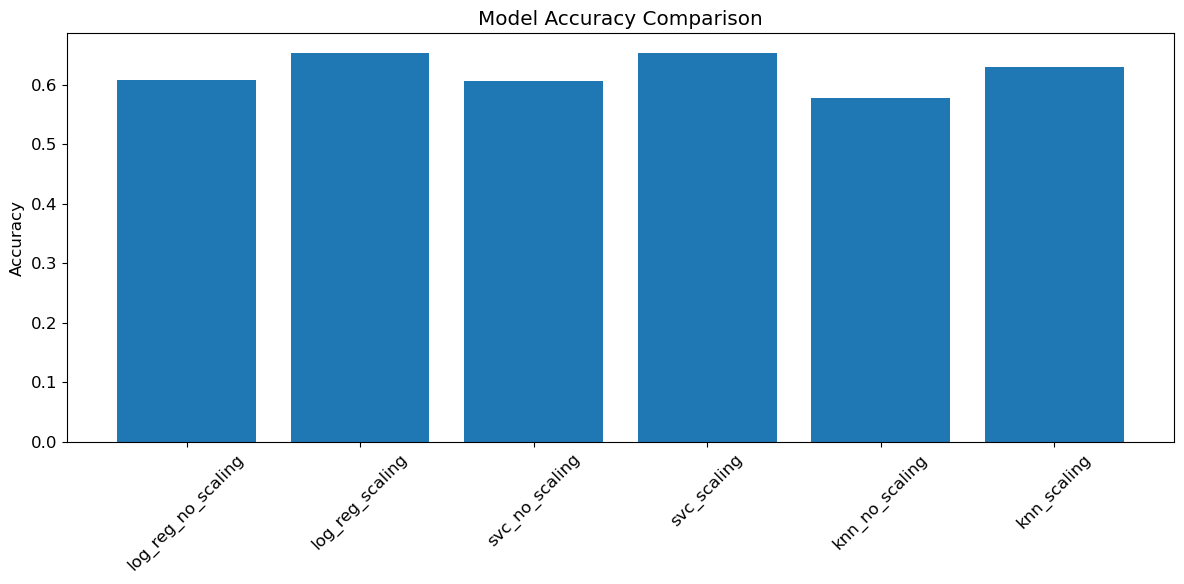

In [91]:
# Visualization of results
plt.figure(figsize=(12, 6))
accuracies = {k: v['accuracy'] for k, v in results.items()}
plt.bar(accuracies.keys(), accuracies.values())
plt.xticks(rotation=45)
plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy')
plt.tight_layout()
plt.show()

In [93]:
# Print comparative summary
print("\nComparative Summary of All Models:")
print("-"*50)
for model_name, metrics in results.items():
    print(f"\n{model_name}:")
    print(f"Accuracy: {metrics['accuracy']:.4f}")
    print(f"F1 Score: {metrics['f1']:.4f}")


Comparative Summary of All Models:
--------------------------------------------------

log_reg_no_scaling:
Accuracy: 0.6084
F1 Score: 0.6045

log_reg_scaling:
Accuracy: 0.6542
F1 Score: 0.6534

svc_no_scaling:
Accuracy: 0.6061
F1 Score: 0.6030

svc_scaling:
Accuracy: 0.6533
F1 Score: 0.6526

knn_no_scaling:
Accuracy: 0.5776
F1 Score: 0.5770

knn_scaling:
Accuracy: 0.6295
F1 Score: 0.6298


The results reveal that feature scaling consistently improves performance across all models, with Logistic Regression and Linear SVC showing the best results (accuracy ~65.4% and ~65.3% respectively). KNN, while benefiting from scaling, performs slightly lower at 62.95% accuracy. Without scaling, model performance drops significantly, particularly for KNN, highlighting the importance of proper feature preprocessing for these algorithms. Logistic Regression emerges as the most effective classifier for this news popularity prediction task, combining good performance with computational efficiency.

## Part B: Tree-based Classifiers

### Decision Tree

In [98]:
# Basic Decision Tree Implementation
print("="*50)
print("Decision Tree Analysis")
print("="*50)

# Train basic decision tree
dt_basic = DecisionTreeClassifier(random_state=42)
dt_basic.fit(X_train, y_train)

# Get predictions and evaluate basic model
y_pred_dt_basic = dt_basic.predict(X_test)
print("\nBasic Decision Tree Results:")
basic_metrics = evaluate_model(y_test, y_pred_dt_basic, "Basic Decision Tree")

Decision Tree Analysis

Basic Decision Tree Results:

Basic Decision Tree Performance Metrics:
Accuracy: 0.5706
Macro-averaged Precision: 0.5694
Macro-averaged Recall: 0.5696
Micro-averaged Precision: 0.5706
Micro-averaged Recall: 0.5706
F1 Score (weighted): 0.5709


The accuracy metrics of this basic model demonstrates that the decision tree performs moderately accurate, with both the precision and recall metrics averaging around 0.57. We can apply grid search and optimize the decision tree parameters to get more accurate results.

In [100]:
# Grid Search for optimal parameters
param_grid_dt = {
    'max_depth': [3, 5, 7, 10, 15, 20],
    'max_features': ['sqrt', 'log2', None]
}

dt_grid = GridSearchCV(
    DecisionTreeClassifier(random_state=42),
    param_grid_dt,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

dt_grid.fit(X_train, y_train)

print("\nGrid Search Results:")
print(f"Best parameters: {dt_grid.best_params_}")
print(f"Best cross-validation accuracy: {dt_grid.best_score_:.4f}")

# Get predictions with best model
y_pred_dt_best = dt_grid.predict(X_test)
best_metrics = evaluate_model(y_test, y_pred_dt_best, "Optimized Decision Tree")


Grid Search Results:
Best parameters: {'max_depth': 7, 'max_features': None}
Best cross-validation accuracy: 0.6411

Optimized Decision Tree Performance Metrics:
Accuracy: 0.6383
Macro-averaged Precision: 0.6368
Macro-averaged Recall: 0.6326
Micro-averaged Precision: 0.6383
Micro-averaged Recall: 0.6383
F1 Score (weighted): 0.6355


According to the grid search results and the decision tree accuracy metrics, the optimal depth for the decision tree is 7 and it's best to use all features at each split. After the cross validation, the model became 64% accurate, while the basic model had shown 57% accuracy, since it ensured the most accuracy yielding selection of parameters. 

With the optimized decision tree which uses the best parameters, we notice that the overall accuracy of the predictions have increased to 0.64 from 0.57.


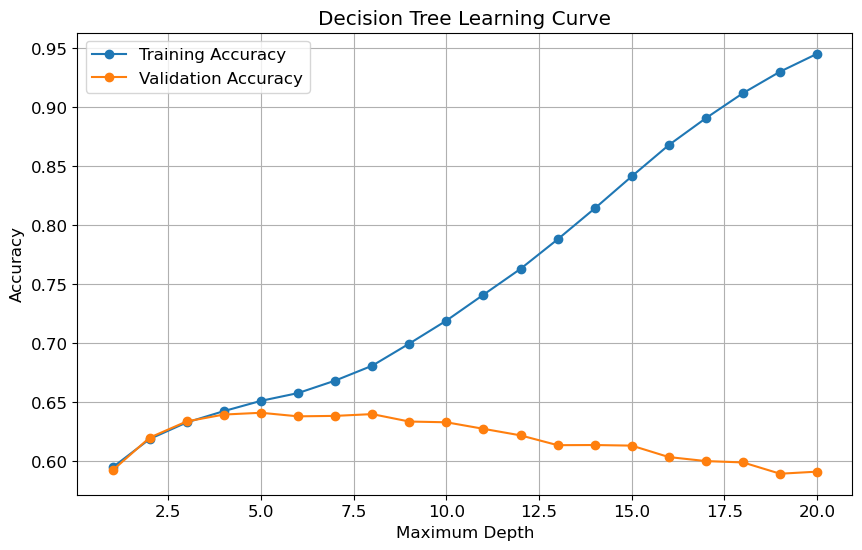

In [102]:
# Learning Curve Analysis
depths = range(1, 21)
train_scores = []
val_scores = []

for depth in depths:
    dt = DecisionTreeClassifier(max_depth=depth, random_state=42)
    dt.fit(X_train, y_train)
    
    # Calculate training and validation scores
    train_score = dt.score(X_train, y_train)
    val_score = dt.score(X_test, y_test)
    
    train_scores.append(train_score)
    val_scores.append(val_score)

# Plot learning curve
plt.figure(figsize=(10, 6))
plt.plot(depths, train_scores, label='Training Accuracy', marker='o')
plt.plot(depths, val_scores, label='Validation Accuracy', marker='o')
plt.xlabel('Maximum Depth')
plt.ylabel('Accuracy')
plt.title('Decision Tree Learning Curve')
plt.legend()
plt.grid(True)

The learning curve shows that the more depth of the trees increases, the accuracy of the training dataset increases, however, the accuracy of the validation set peaks at a point between 2.5 and 5.0, and continuously decreases afterwards, this happens because the model overfits the training data. In order to prevent overfitting, we should use the optimal depth value. 

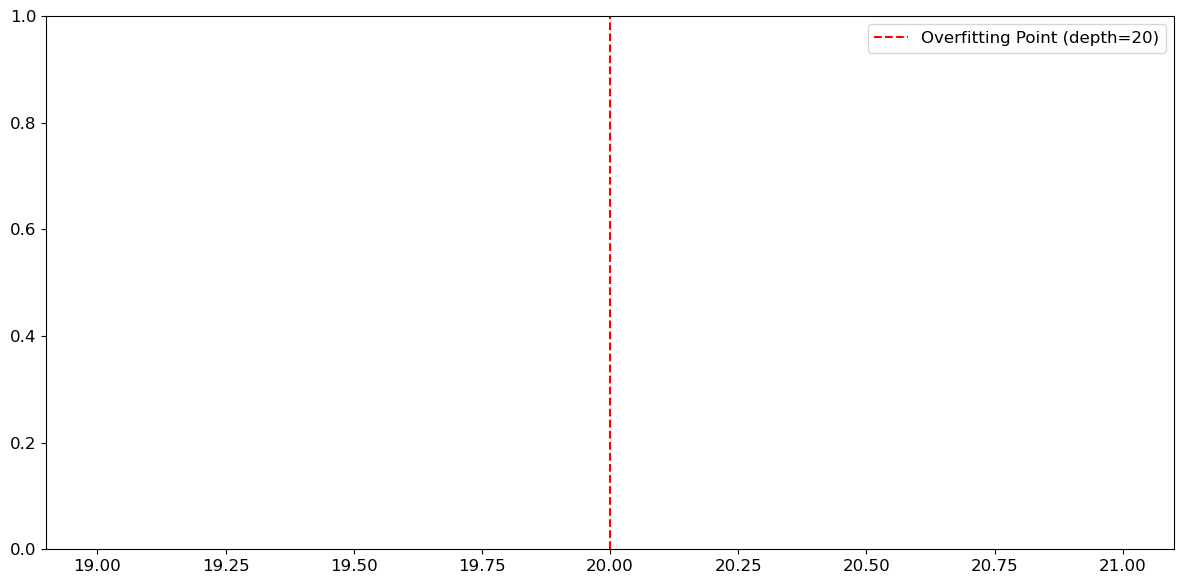

In [104]:
# Find overfitting point
diff_scores = np.array(train_scores) - np.array(val_scores)
overfitting_point = depths[np.argmax(diff_scores)]
max_diff = np.max(diff_scores)


plt.axvline(x=overfitting_point, color='r', linestyle='--', 
            label=f'Overfitting Point (depth={overfitting_point})')
plt.legend()
plt.tight_layout()
plt.show()

The overfitting point of the learning curve seems to be 20.

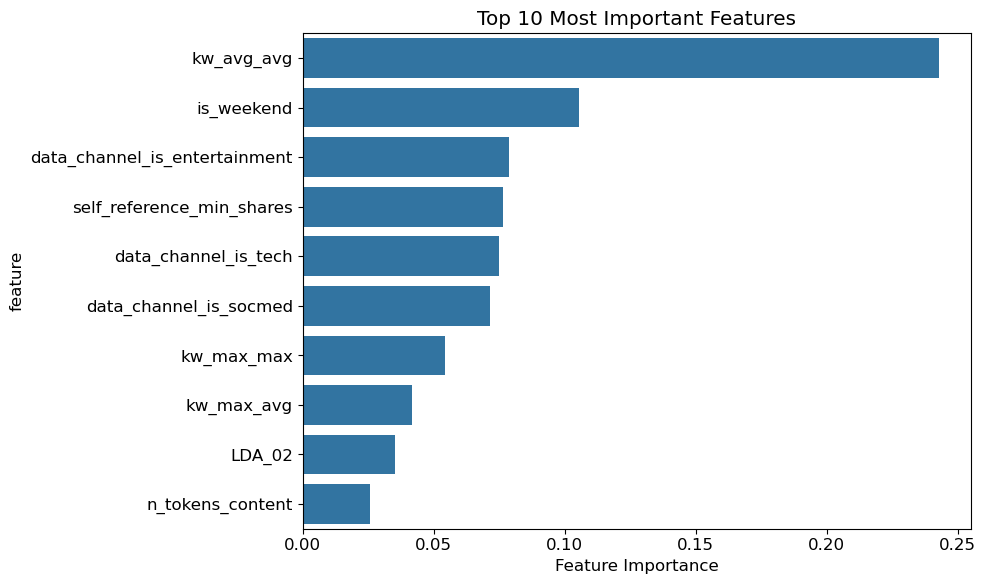

In [106]:
# Feature importance analysis
best_dt = dt_grid.best_estimator_
feature_importance = pd.DataFrame({
    'feature': feature_names,
    'importance': best_dt.feature_importances_
})
feature_importance = feature_importance.sort_values('importance', ascending=False).head(10)

plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance, x='importance', y='feature')
plt.title('Top 10 Most Important Features')
plt.xlabel('Feature Importance')
plt.tight_layout()
plt.show()

This graph shows the top 10 most important features in the decision tree model.

In [108]:
# Print analysis summary
print("\nDecision Tree Analysis Summary:")
print("-"*50)
print(f"Optimal max_depth: {dt_grid.best_params_['max_depth']}")
print(f"Optimal max_features: {dt_grid.best_params_['max_features']}")
print(f"Overfitting begins at depth: {overfitting_point}")
print(f"Maximum train-test accuracy gap: {max_diff:.4f}")

print("\nBrief Analysis:")
print(f"The decision tree shows optimal performance at depth {dt_grid.best_params_['max_depth']}, "
      f"with overfitting becoming apparent at depth {overfitting_point}. "
      f"The model achieves {best_metrics['accuracy']:.4f} test accuracy with the optimal parameters.")


Decision Tree Analysis Summary:
--------------------------------------------------
Optimal max_depth: 7
Optimal max_features: None
Overfitting begins at depth: 20
Maximum train-test accuracy gap: 0.3545

Brief Analysis:
The decision tree shows optimal performance at depth 7, with overfitting becoming apparent at depth 20. The model achieves 0.6383 test accuracy with the optimal parameters.


### Random Forest

In [113]:
# Basic Random Forest Implementation
print("="*50)
print("Random Forest Analysis")
print("="*50)

# Train basic random forest
rf_basic = RandomForestClassifier(random_state=42)
rf_basic.fit(X_train, y_train)

# Get predictions and evaluate basic model
y_pred_rf_basic = rf_basic.predict(X_test)
print("\nBasic Random Forest Results:")
rf_basic_metrics = evaluate_model(y_test, y_pred_rf_basic, "Basic Random Forest")

Random Forest Analysis

Basic Random Forest Results:

Basic Random Forest Performance Metrics:
Accuracy: 0.6565
Macro-averaged Precision: 0.6547
Macro-averaged Recall: 0.6526
Micro-averaged Precision: 0.6565
Micro-averaged Recall: 0.6565
F1 Score (weighted): 0.6553


The accuracy metrics of the basic random forest model demonstrate that it performs moderately well, with an overall accuracy of 0.65. We can further enhance the model by applying grid search to optimize its parameters.

In [115]:
# Grid Search for optimal parameters
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15, None],
    'max_features': ['sqrt', 'log2']
}

rf_grid = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid_rf,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

rf_grid.fit(X_train, y_train)

print("\nGrid Search Results:")
print(f"Best parameters: {rf_grid.best_params_}")
print(f"Best cross-validation accuracy: {rf_grid.best_score_:.4f}")


Grid Search Results:
Best parameters: {'max_depth': None, 'max_features': 'log2', 'n_estimators': 300}
Best cross-validation accuracy: 0.6724


According to the grid search results, the optimal random forest model involves using 300 trees (n_estimators). After tuning, the model achieved a cross-validation accuracy of 0.67, while the basic model accuracy was 0.65.

In [131]:
# Get predictions with best model
y_pred_rf_best = rf_grid.predict(X_test)
rf_best_metrics = evaluate_model(y_test, y_pred_rf_best, "Optimized Random Forest")


Optimized Random Forest Performance Metrics:
Accuracy: 0.6640
Macro-averaged Precision: 0.6626
Macro-averaged Recall: 0.6597
Micro-averaged Precision: 0.6640
Micro-averaged Recall: 0.6640
F1 Score (weighted): 0.6625


With the optimized random forest model, the overall accuracy improved to 0.6640, from 0.6565 in the basic model. This suggests that fine-tuning the hyperparameters allows the random forest model to make more accurate predictions.

In [133]:
# Compare with Decision Tree results
print("\nComparison with Decision Tree:")
print(f"Decision Tree Accuracy: {best_metrics['accuracy']:.4f}")
print(f"Random Forest Accuracy: {rf_best_metrics['accuracy']:.4f}")
print(f"Improvement: {(rf_best_metrics['accuracy'] - best_metrics['accuracy'])*100:.2f}%")


Comparison with Decision Tree:
Decision Tree Accuracy: 0.6383
Random Forest Accuracy: 0.6640
Improvement: 2.57%


The accuracy metrics of the decision tree and the random forest model shows that the random forest model yields more accurate predictions, with a difference of 2.57%.

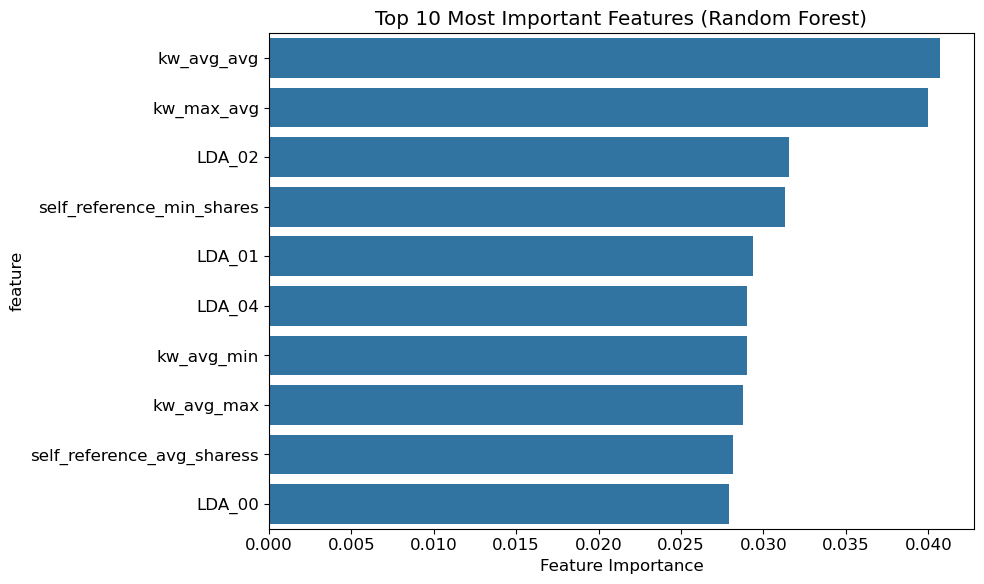

In [135]:
# Feature importance analysis for Random Forest
best_rf = rf_grid.best_estimator_
rf_feature_importance = pd.DataFrame({
    'feature': feature_names,
    'importance': best_rf.feature_importances_
})
rf_feature_importance = rf_feature_importance.sort_values('importance', ascending=False).head(10)

plt.figure(figsize=(10, 6))
sns.barplot(data=rf_feature_importance, x='importance', y='feature')
plt.title('Top 10 Most Important Features (Random Forest)')
plt.xlabel('Feature Importance')
plt.tight_layout()
plt.show()

This graph shows the top 10 most important features of the random forest model.

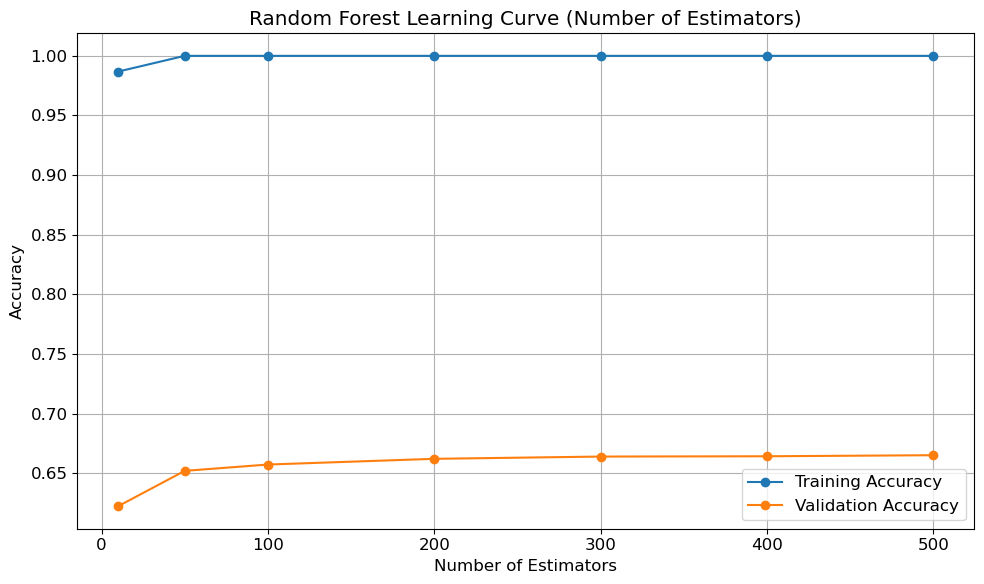

In [137]:
# Learning curve analysis for number of estimators
n_estimators_range = [10, 50, 100, 200, 300, 400, 500]
train_scores_rf = []
val_scores_rf = []

for n_est in n_estimators_range:
    rf = RandomForestClassifier(
        n_estimators=n_est,
        max_depth=rf_grid.best_params_['max_depth'],
        max_features=rf_grid.best_params_['max_features'],
        random_state=42
    )
    rf.fit(X_train, y_train)
    
    train_scores_rf.append(rf.score(X_train, y_train))
    val_scores_rf.append(rf.score(X_test, y_test))

# Plot learning curve for number of estimators
plt.figure(figsize=(10, 6))
plt.plot(n_estimators_range, train_scores_rf, label='Training Accuracy', marker='o')
plt.plot(n_estimators_range, val_scores_rf, label='Validation Accuracy', marker='o')
plt.xlabel('Number of Estimators')
plt.ylabel('Accuracy')
plt.title('Random Forest Learning Curve (Number of Estimators)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

The learning curve shows that as the number of estimators increases, the training accuracy stays high at 1.0, but the validation accuracy peaks around 300 estimators and then levels off. This suggests the model performs best with around 300 estimators, and adding more doesn’t help. To avoid overfitting, we should pick the optimal number of estimators based on the validation accuracy.

In [140]:
# Comparative analysis
print("\nComparative Analysis:")
print("-"*50)
print("\n1. Decision Trees vs Random Forests:")
print(f"- Decision Tree best accuracy: {best_metrics['accuracy']:.4f}")
print(f"- Random Forest best accuracy: {rf_best_metrics['accuracy']:.4f}")
print("- Random Forest shows better generalization and robustness against overfitting")
print("- Random Forest has more stable feature importance estimates")

print("\n2. Usage Scenarios:")
print("Decision Trees:")
print("- When interpretability is crucial")
print("- When computational resources are limited")
print("- When the dataset is small and simple")

print("\nRandom Forests:")
print("- When maximum prediction accuracy is needed")
print("- When dealing with complex, high-dimensional data")
print("- When robust feature importance estimates are required")

print("\n3. Accuracy Metric Appropriateness:")
print("- Accuracy might not be the best metric if classes are imbalanced")
print(f"- Class distribution in test set: {dict(y_test.value_counts(normalize=True).round(3))}")
print("- Consider using F1-score, precision, recall for imbalanced cases")


Comparative Analysis:
--------------------------------------------------

1. Decision Trees vs Random Forests:
- Decision Tree best accuracy: 0.6383
- Random Forest best accuracy: 0.6640
- Random Forest shows better generalization and robustness against overfitting
- Random Forest has more stable feature importance estimates

2. Usage Scenarios:
Decision Trees:
- When interpretability is crucial
- When computational resources are limited
- When the dataset is small and simple

Random Forests:
- When maximum prediction accuracy is needed
- When dealing with complex, high-dimensional data
- When robust feature importance estimates are required

3. Accuracy Metric Appropriateness:
- Accuracy might not be the best metric if classes are imbalanced
- Class distribution in test set: {1: 0.534, 0: 0.466}
- Consider using F1-score, precision, recall for imbalanced cases


In [142]:
# Performance stability analysis
n_iterations = 5
rf_scores = []
dt_scores = []

for i in range(n_iterations):
    # Random Forest
    rf = RandomForestClassifier(**rf_grid.best_params_, random_state=i)
    rf.fit(X_train, y_train)
    rf_scores.append(rf.score(X_test, y_test))
    
    # Decision Tree
    dt = DecisionTreeClassifier(**dt_grid.best_params_, random_state=i)
    dt.fit(X_train, y_train)
    dt_scores.append(dt.score(X_test, y_test))

print("\nStability Analysis:")
print(f"Random Forest score std: {np.std(rf_scores):.4f}")
print(f"Decision Tree score std: {np.std(dt_scores):.4f}")


Stability Analysis:
Random Forest score std: 0.0025
Decision Tree score std: 0.0001


The stability analysis shows that the Random Forest model has a higher score standard deviation compared to the Decision Tree. This indicates that the Decision Tree is more stable and consistent in its performance, while the Random Forest model shows more variation in its results.

### Robustness Testing

Robustness Testing Analysis


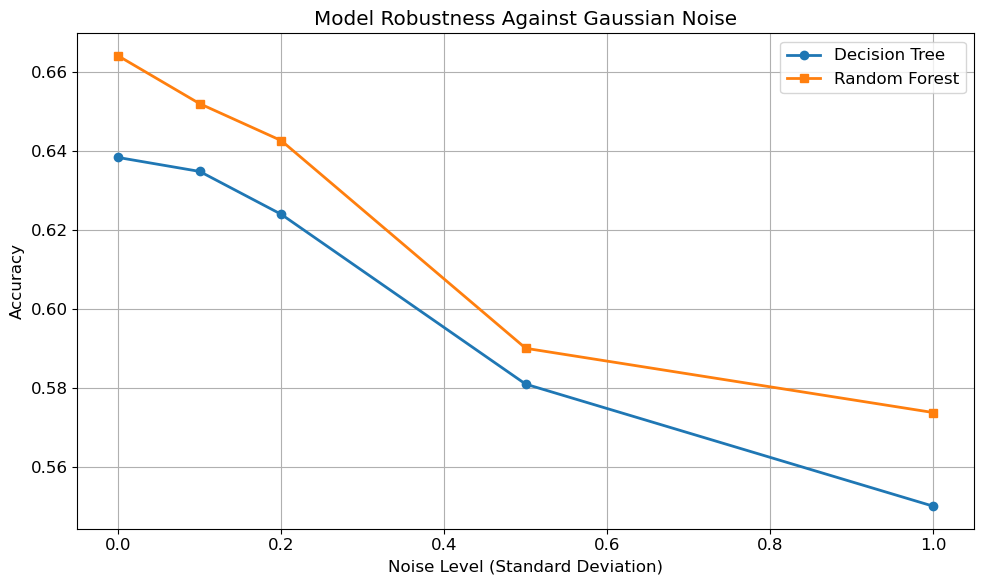

In [144]:
# Robustness Testing Implementation
print("="*50)
print("Robustness Testing Analysis")
print("="*50)

# Get the best models from previous grid searches
best_dt = dt_grid.best_estimator_
best_rf = rf_grid.best_estimator_

# Define noise levels
noise_levels = [0, 0.1, 0.2, 0.5, 1.0]
dt_scores = []
rf_scores = []

# Function to add Gaussian noise to data
def add_noise(X, noise_level):
    noise = np.random.normal(0, noise_level, X.shape)
    return X + noise

# Create and test noisy datasets
for noise_level in noise_levels:
    # Create noisy test set
    X_test_noisy = add_noise(X_test.copy(), noise_level)
    
    # Get predictions and scores for both models
    dt_score = best_dt.score(X_test_noisy, y_test)
    rf_score = best_rf.score(X_test_noisy, y_test)
    
    dt_scores.append(dt_score)
    rf_scores.append(rf_score)

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(noise_levels, dt_scores, marker='o', label='Decision Tree', linewidth=2)
plt.plot(noise_levels, rf_scores, marker='s', label='Random Forest', linewidth=2)
plt.xlabel('Noise Level (Standard Deviation)')
plt.ylabel('Accuracy')
plt.title('Model Robustness Against Gaussian Noise')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

The random forest model seems to be more sensitive to gaussian noise, which shows that the decision tree model is more durable and consistent in accuracy.

In [148]:
# Calculate relative performance degradation
dt_degradation = (dt_scores[0] - dt_scores[-1]) / dt_scores[0] * 100
rf_degradation = (rf_scores[0] - rf_scores[-1]) / rf_scores[0] * 100

# Detailed analysis
print("\nRobustness Analysis:")
print("-"*50)
print("\nAccuracy at different noise levels:")
print("\nNoise Level | Decision Tree | Random Forest")
print("-"*45)
for i, noise in enumerate(noise_levels):
    print(f"{noise:10.1f} | {dt_scores[i]:12.4f} | {rf_scores[i]:12.4f}")

print("\nPerformance Degradation:")
print(f"Decision Tree: {dt_degradation:.2f}% decrease from noise=0 to noise=1.0")
print(f"Random Forest: {rf_degradation:.2f}% decrease from noise=0 to noise=1.0")

# Statistical analysis of robustness
dt_std = np.std(dt_scores)
rf_std = np.std(rf_scores)

print("\nStability Metrics:")
print(f"Decision Tree accuracy standard deviation: {dt_std:.4f}")
print(f"Random Forest accuracy standard deviation: {rf_std:.4f}")


Robustness Analysis:
--------------------------------------------------

Accuracy at different noise levels:

Noise Level | Decision Tree | Random Forest
---------------------------------------------
       0.0 |       0.6383 |       0.6640
       0.1 |       0.6348 |       0.6519
       0.2 |       0.6239 |       0.6426
       0.5 |       0.5809 |       0.5900
       1.0 |       0.5500 |       0.5737

Performance Degradation:
Decision Tree: 13.83% decrease from noise=0 to noise=1.0
Random Forest: 13.60% decrease from noise=0 to noise=1.0

Stability Metrics:
Decision Tree accuracy standard deviation: 0.0345
Random Forest accuracy standard deviation: 0.0358


As noise increases, the performance of both models decreases. The Decision Tree shows a 13.83% decrease in accuracy from a noise level of 0.0 to 1.0, while the Random Forest shows a slightly smaller decrease of 13.60%. 

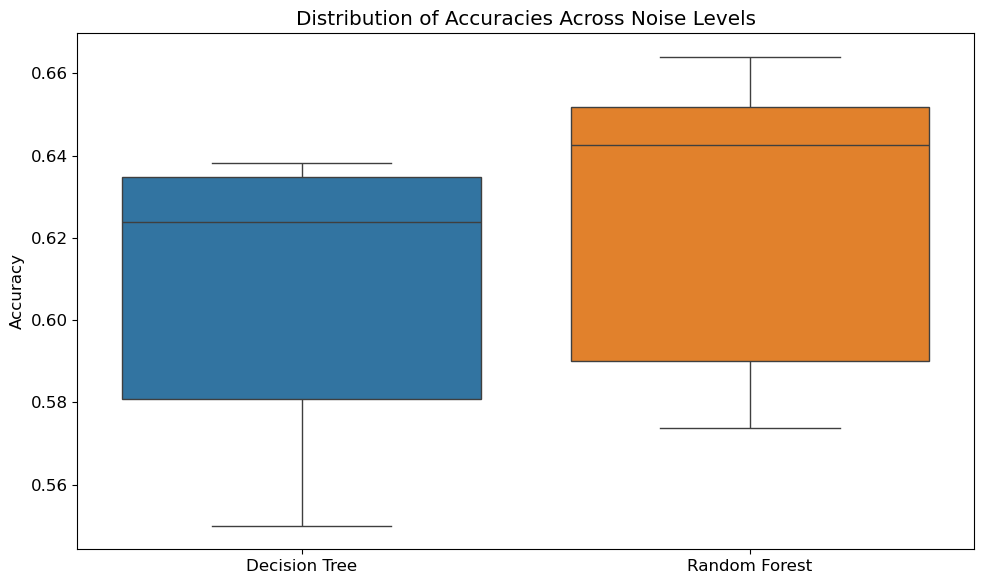

In [150]:
# Box plot of accuracies across noise levels
plt.figure(figsize=(10, 6))
data = pd.DataFrame({
    'Decision Tree': dt_scores,
    'Random Forest': rf_scores
})
sns.boxplot(data=data)
plt.title('Distribution of Accuracies Across Noise Levels')
plt.ylabel('Accuracy')
plt.tight_layout()
plt.show()

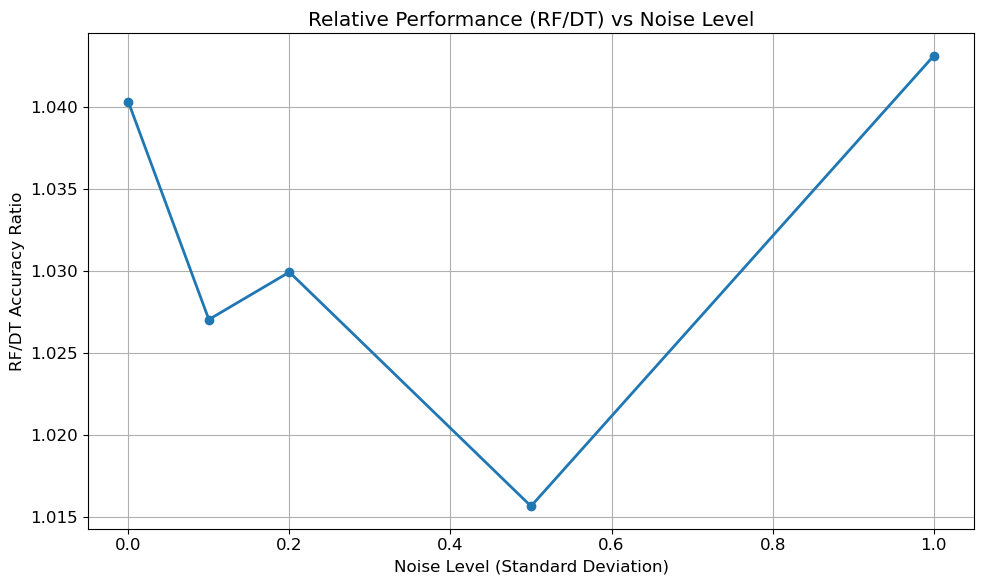

In [152]:
# Relative performance ratio
performance_ratio = np.array(rf_scores) / np.array(dt_scores)

plt.figure(figsize=(10, 6))
plt.plot(noise_levels, performance_ratio, marker='o', linewidth=2)
plt.xlabel('Noise Level (Standard Deviation)')
plt.ylabel('RF/DT Accuracy Ratio')
plt.title('Relative Performance (RF/DT) vs Noise Level')
plt.grid(True)
plt.tight_layout()
plt.show()

In [154]:
# Calculate area under performance curve (AUC)
dt_auc = np.trapz(dt_scores, noise_levels)
rf_auc = np.trapz(rf_scores, noise_levels)

print("\nArea Under Performance Curve:")
print(f"Decision Tree AUC: {dt_auc:.4f}")
print(f"Random Forest AUC: {rf_auc:.4f}")
print(f"RF/DT AUC Ratio: {rf_auc/dt_auc:.4f}")


Area Under Performance Curve:
Decision Tree AUC: 0.5900
Random Forest AUC: 0.6063
RF/DT AUC Ratio: 1.0276


The AUC analysis shows that the Random Forest model outperforms the Decision Tree model. The Random Forest has an AUC of 0.6063, while the Decision Tree's AUC is 0.5900. The RF/DT AUC ratio is 1.0276, indicating that the Random Forest model provides a slightly better overall performance compared to the Decision Tree model.

### ROC Curves and AUC

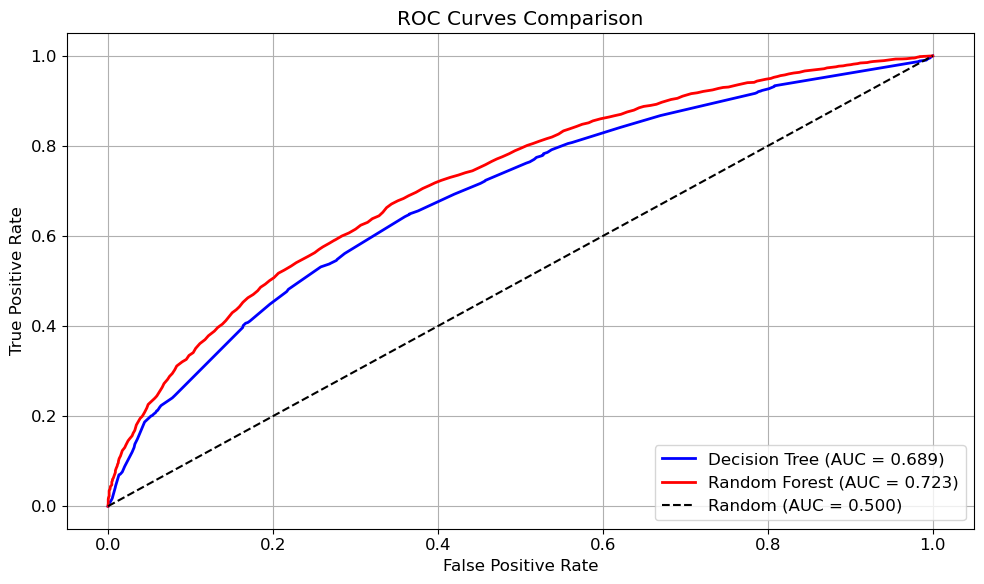

In [163]:
# Get probability predictions for original test set
dt_probs = best_dt.predict_proba(X_test)[:, 1]
rf_probs = best_rf.predict_proba(X_test)[:, 1]

# Calculate ROC curves
dt_fpr, dt_tpr, _ = roc_curve(y_test, dt_probs)
rf_fpr, rf_tpr, _ = roc_curve(y_test, rf_probs)

# Calculate AUC scores
dt_auc = auc(dt_fpr, dt_tpr)
rf_auc = auc(rf_fpr, rf_tpr)

# Plot ROC curves
plt.figure(figsize=(10, 6))
plt.plot(dt_fpr, dt_tpr, label=f'Decision Tree (AUC = {dt_auc:.3f})', 
         linewidth=2, color='blue')
plt.plot(rf_fpr, rf_tpr, label=f'Random Forest (AUC = {rf_auc:.3f})', 
         linewidth=2, color='red')
plt.plot([0, 1], [0, 1], 'k--', label='Random (AUC = 0.500)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves Comparison')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

The diagonal line in the plot represents the "random" classifier, with an AUC of 0.500, used for comparison. The closer the curve is to the top-left corner, the better the model's performance.

### Conclusion

In conclusion, both the Decision Tree and Random Forest models showed decent performance, with the Random Forest slightly outperforming the Decision Tree in most areas. The Random Forest model demonstrated higher accuracy, stability, and robustness against noise, as well as a better AUC score in the ROC curve analysis. While both models experienced performance degradation with increasing noise, Random Forest remained more stable. Overall, the Random Forest model is a more reliable choice for this classification task.